# [TUM - miniprojekt] Przebieg procesu uczenia dla sieci przy użyciu różnych algorytmów optymalizacji
## Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395)

In [1]:
# %pip install torch torchvision tqdm pandas matplotlib seaborn

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
DATASET_PATH: str = "./datasets"
MODEL_PATH: str = "./models"
RESULT_PATH: str = "./results"

BATCH_SIZE: int = 4

In [4]:
def get_dataset(dataset, batch_size: int = BATCH_SIZE) -> tuple:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=True)
    valid_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=False)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [5]:
datasets = {
    "FashionMNIST": torchvision.datasets.FashionMNIST,
    "MNIST": torchvision.datasets.MNIST,
}

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


class CNNClassifier(nn.Module):
    def __init__(self, number_of_channels: int = 1, number_of_classes: int = 10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(number_of_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
optimizers = {
    "SGD": optim.SGD,
    "AdaGrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
}

In [8]:
loss_fn = nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer) -> float:
    model.train()
    optimizer = optimizer(model.parameters(), lr=1e-3)

    running_loss = 0.0
    avg_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            avg_loss = running_loss / 1000
            print(f"[{i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0

    return avg_loss


def valid_epoch(model, valid_loader) -> float:
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / (i + 1)
    return avg_loss

In [9]:
NUMBER_OF_EPOCHS: int = 30

In [10]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name, optimizer in optimizers.items():
        print(f"OPTIMIZER: {optimizer_name}")

        model = CNNClassifier()
        model.to(device)

        best_vloss = np.inf

        results: list = []

        for epoch_number in range(NUMBER_OF_EPOCHS):
            print(f"EPOCH: {epoch_number + 1} / {NUMBER_OF_EPOCHS}")

            avg_loss = train_epoch(model, train_loader, optimizer)

            avg_vloss = valid_epoch(model, valid_loader)

            results.append(
                {
                    "epoch": epoch_number,
                    "train_loss": avg_loss,
                    "valid_loss": avg_vloss,
                }
            )

            print(f"Train Loss: {avg_loss:.3f}, Valid Loss: {avg_vloss:.3f}")

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                if not os.path.exists(MODEL_PATH):
                    os.makedirs(MODEL_PATH)
                torch.save(
                    model.state_dict(), f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"
                )
            else:
                print(
                    f"Early stopping (no improvement in validation loss in epoch {epoch_number + 1})"
                )
                break

        results_df = pd.DataFrame(results)
        if not os.path.exists(RESULT_PATH):
            os.makedirs(RESULT_PATH)
        results_df.to_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv", index=False)

DATASET: FashionMNIST
OPTIMIZER: SGD
EPOCH: 1 / 2


  7%|▋         | 1063/15000 [00:03<00:35, 395.68it/s]

[ 1000] loss: 2.304


 14%|█▎        | 2043/15000 [00:05<00:31, 405.39it/s]

[ 2000] loss: 2.299


 21%|██        | 3080/15000 [00:08<00:29, 409.86it/s]

[ 3000] loss: 2.294


 27%|██▋       | 4074/15000 [00:10<00:26, 404.74it/s]

[ 4000] loss: 2.285


 34%|███▍      | 5063/15000 [00:13<00:24, 407.16it/s]

[ 5000] loss: 2.268


 41%|████      | 6080/15000 [00:15<00:23, 380.63it/s]

[ 6000] loss: 2.234


 47%|████▋     | 7062/15000 [00:18<00:19, 407.01it/s]

[ 7000] loss: 2.117


 54%|█████▎    | 8059/15000 [00:21<00:17, 406.84it/s]

[ 8000] loss: 1.689


 60%|██████    | 9065/15000 [00:23<00:14, 414.08it/s]

[ 9000] loss: 1.151


 67%|██████▋   | 10073/15000 [00:26<00:11, 412.77it/s]

[10000] loss: 0.916


 74%|███████▍  | 11072/15000 [00:28<00:09, 411.65it/s]

[11000] loss: 0.847


 80%|████████  | 12074/15000 [00:30<00:07, 409.64it/s]

[12000] loss: 0.799


 87%|████████▋ | 13079/15000 [00:33<00:04, 412.36it/s]

[13000] loss: 0.763


 94%|█████████▎| 14045/15000 [00:35<00:02, 413.04it/s]

[14000] loss: 0.769


100%|██████████| 15000/15000 [00:38<00:00, 391.79it/s]


[15000] loss: 0.690


100%|██████████| 2500/2500 [00:02<00:00, 862.52it/s]


Train Loss: 0.690, Valid Loss: 0.710
EPOCH: 2 / 2


  7%|▋         | 1044/15000 [00:02<00:33, 412.89it/s]

[ 1000] loss: 0.707


 14%|█▎        | 2052/15000 [00:04<00:31, 412.97it/s]

[ 2000] loss: 0.699


 20%|██        | 3056/15000 [00:07<00:29, 409.60it/s]

[ 3000] loss: 0.644


 27%|██▋       | 4056/15000 [00:09<00:26, 409.69it/s]

[ 4000] loss: 0.658


 34%|███▍      | 5064/15000 [00:12<00:23, 415.84it/s]

[ 5000] loss: 0.623


 40%|████      | 6072/15000 [00:14<00:21, 413.65it/s]

[ 6000] loss: 0.642


 47%|████▋     | 7082/15000 [00:17<00:19, 413.50it/s]

[ 7000] loss: 0.609


 54%|█████▎    | 8049/15000 [00:19<00:16, 416.90it/s]

[ 8000] loss: 0.609


 60%|██████    | 9011/15000 [00:21<00:16, 360.22it/s]

[ 9000] loss: 0.591


 67%|██████▋   | 10072/15000 [00:25<00:13, 362.24it/s]

[10000] loss: 0.595


 74%|███████▎  | 11047/15000 [00:27<00:09, 412.27it/s]

[11000] loss: 0.602


 80%|████████  | 12055/15000 [00:30<00:07, 399.91it/s]

[12000] loss: 0.568


 87%|████████▋ | 13070/15000 [00:32<00:05, 383.22it/s]

[13000] loss: 0.570


 94%|█████████▎| 14049/15000 [00:35<00:02, 377.60it/s]

[14000] loss: 0.555


100%|██████████| 15000/15000 [00:37<00:00, 398.04it/s]


[15000] loss: 0.553


100%|██████████| 2500/2500 [00:02<00:00, 846.29it/s]


Train Loss: 0.553, Valid Loss: 0.564
OPTIMIZER: AdaGrad
EPOCH: 1 / 2


  7%|▋         | 1049/15000 [00:03<00:41, 336.57it/s]

[ 1000] loss: 1.601


 14%|█▎        | 2038/15000 [00:06<00:38, 333.61it/s]

[ 2000] loss: 1.093


 20%|██        | 3042/15000 [00:09<00:35, 339.40it/s]

[ 3000] loss: 0.996


 27%|██▋       | 4061/15000 [00:12<00:32, 339.45it/s]

[ 4000] loss: 0.948


 34%|███▎      | 5037/15000 [00:15<00:32, 302.24it/s]

[ 5000] loss: 0.909


 40%|████      | 6040/15000 [00:18<00:26, 335.70it/s]

[ 6000] loss: 0.906


 47%|████▋     | 7060/15000 [00:21<00:23, 336.78it/s]

[ 7000] loss: 0.863


 54%|█████▎    | 8046/15000 [00:24<00:20, 336.93it/s]

[ 8000] loss: 0.862


 60%|██████    | 9066/15000 [00:27<00:17, 335.96it/s]

[ 9000] loss: 0.839


 67%|██████▋   | 10061/15000 [00:30<00:14, 340.15it/s]

[10000] loss: 0.813


 74%|███████▎  | 11051/15000 [00:33<00:11, 337.17it/s]

[11000] loss: 0.844


 80%|████████  | 12063/15000 [00:37<00:08, 329.37it/s]

[12000] loss: 0.800


 87%|████████▋ | 13052/15000 [00:40<00:05, 333.80it/s]

[13000] loss: 0.794


 94%|█████████▎| 14037/15000 [00:43<00:02, 332.62it/s]

[14000] loss: 0.779


100%|██████████| 15000/15000 [00:45<00:00, 326.46it/s]


[15000] loss: 0.772


100%|██████████| 2500/2500 [00:02<00:00, 869.57it/s]


Train Loss: 0.772, Valid Loss: 0.796
EPOCH: 2 / 2


  7%|▋         | 1029/15000 [00:03<01:03, 220.26it/s]

[ 1000] loss: 0.776


 14%|█▎        | 2045/15000 [00:06<00:38, 332.37it/s]

[ 2000] loss: 0.717


 20%|██        | 3033/15000 [00:09<00:36, 332.01it/s]

[ 3000] loss: 0.743


 27%|██▋       | 4059/15000 [00:12<00:32, 338.95it/s]

[ 4000] loss: 0.732


 34%|███▎      | 5050/15000 [00:15<00:29, 333.96it/s]

[ 5000] loss: 0.720


 40%|████      | 6064/15000 [00:18<00:30, 291.94it/s]

[ 6000] loss: 0.709


 47%|████▋     | 7041/15000 [00:21<00:23, 333.96it/s]

[ 7000] loss: 0.701


 54%|█████▎    | 8062/15000 [00:24<00:21, 319.13it/s]

[ 8000] loss: 0.691


 60%|██████    | 9048/15000 [00:27<00:17, 337.14it/s]

[ 9000] loss: 0.695


 67%|██████▋   | 10036/15000 [00:30<00:14, 336.87it/s]

[10000] loss: 0.675


 74%|███████▎  | 11057/15000 [00:33<00:11, 336.98it/s]

[11000] loss: 0.684


 80%|████████  | 12046/15000 [00:36<00:08, 334.82it/s]

[12000] loss: 0.659


 87%|████████▋ | 13061/15000 [00:39<00:05, 332.11it/s]

[13000] loss: 0.662


 94%|█████████▎| 14049/15000 [00:42<00:02, 334.79it/s]

[14000] loss: 0.657


100%|██████████| 15000/15000 [00:45<00:00, 327.54it/s]


[15000] loss: 0.648


100%|██████████| 2500/2500 [00:02<00:00, 864.65it/s]


Train Loss: 0.648, Valid Loss: 0.680
OPTIMIZER: Adam
EPOCH: 1 / 2


  7%|▋         | 1033/15000 [00:04<01:13, 190.70it/s]

[ 1000] loss: 0.936


 14%|█▎        | 2048/15000 [00:08<00:48, 266.69it/s]

[ 2000] loss: 0.656


 20%|██        | 3047/15000 [00:11<00:44, 268.40it/s]

[ 3000] loss: 0.569


 27%|██▋       | 4040/15000 [00:15<00:42, 260.53it/s]

[ 4000] loss: 0.512


 34%|███▎      | 5028/15000 [00:19<00:37, 266.98it/s]

[ 5000] loss: 0.472


 40%|████      | 6028/15000 [00:23<00:38, 234.45it/s]

[ 6000] loss: 0.487


 47%|████▋     | 7041/15000 [00:27<00:29, 267.89it/s]

[ 7000] loss: 0.438


 54%|█████▎    | 8036/15000 [00:31<00:25, 268.56it/s]

[ 8000] loss: 0.432


 60%|██████    | 9022/15000 [00:35<00:26, 229.39it/s]

[ 9000] loss: 0.450


 67%|██████▋   | 10043/15000 [00:39<00:18, 266.90it/s]

[10000] loss: 0.403


 74%|███████▎  | 11041/15000 [00:43<00:15, 256.48it/s]

[11000] loss: 0.394


 80%|████████  | 12037/15000 [00:47<00:11, 267.78it/s]

[12000] loss: 0.374


 87%|████████▋ | 13030/15000 [00:51<00:07, 270.11it/s]

[13000] loss: 0.391


 94%|█████████▎| 14033/15000 [00:55<00:04, 238.74it/s]

[14000] loss: 0.375


100%|██████████| 15000/15000 [00:59<00:00, 252.80it/s]


[15000] loss: 0.377


100%|██████████| 2500/2500 [00:03<00:00, 746.05it/s]


Train Loss: 0.377, Valid Loss: 0.378
EPOCH: 2 / 2


  7%|▋         | 1047/15000 [00:03<00:52, 268.24it/s]

[ 1000] loss: 0.349


 14%|█▎        | 2053/15000 [00:07<00:48, 266.80it/s]

[ 2000] loss: 0.354


 20%|██        | 3052/15000 [00:11<00:44, 268.34it/s]

[ 3000] loss: 0.362


 27%|██▋       | 4052/15000 [00:15<00:40, 268.13it/s]

[ 4000] loss: 0.374


 34%|███▎      | 5053/15000 [00:19<00:37, 268.59it/s]

[ 5000] loss: 0.350


 40%|████      | 6029/15000 [00:22<00:33, 265.21it/s]

[ 6000] loss: 0.366


 47%|████▋     | 7032/15000 [00:26<00:29, 269.02it/s]

[ 7000] loss: 0.325


 54%|█████▎    | 8032/15000 [00:30<00:26, 266.69it/s]

[ 8000] loss: 0.351


 60%|██████    | 9038/15000 [00:34<00:22, 262.22it/s]

[ 9000] loss: 0.345


 67%|██████▋   | 10044/15000 [00:38<00:18, 261.55it/s]

[10000] loss: 0.341


 74%|███████▎  | 11045/15000 [00:42<00:14, 268.88it/s]

[11000] loss: 0.333


 80%|████████  | 12047/15000 [00:46<00:11, 265.27it/s]

[12000] loss: 0.373


 87%|████████▋ | 13046/15000 [00:49<00:07, 265.96it/s]

[13000] loss: 0.341


 94%|█████████▎| 14047/15000 [00:53<00:03, 268.42it/s]

[14000] loss: 0.328


100%|██████████| 15000/15000 [00:57<00:00, 261.87it/s]


[15000] loss: 0.344


100%|██████████| 2500/2500 [00:02<00:00, 849.31it/s]


Train Loss: 0.344, Valid Loss: 0.373
OPTIMIZER: AdamW
EPOCH: 1 / 2


  7%|▋         | 1040/15000 [00:04<00:56, 247.02it/s]

[ 1000] loss: 0.913


 14%|█▎        | 2029/15000 [00:08<00:51, 250.01it/s]

[ 2000] loss: 0.653


 20%|██        | 3049/15000 [00:12<00:47, 250.68it/s]

[ 3000] loss: 0.589


 27%|██▋       | 4046/15000 [00:16<00:43, 250.41it/s]

[ 4000] loss: 0.538


 34%|███▎      | 5030/15000 [00:20<00:39, 251.59it/s]

[ 5000] loss: 0.475


 40%|████      | 6032/15000 [00:24<00:35, 250.30it/s]

[ 6000] loss: 0.465


 47%|████▋     | 7040/15000 [00:28<00:31, 249.69it/s]

[ 7000] loss: 0.439


 54%|█████▎    | 8047/15000 [00:32<00:28, 247.54it/s]

[ 8000] loss: 0.448


 60%|██████    | 9028/15000 [00:36<00:23, 250.59it/s]

[ 9000] loss: 0.430


 67%|██████▋   | 10049/15000 [00:40<00:19, 249.88it/s]

[10000] loss: 0.398


 74%|███████▎  | 11040/15000 [00:44<00:15, 248.84it/s]

[11000] loss: 0.414


 80%|████████  | 12037/15000 [00:48<00:11, 250.76it/s]

[12000] loss: 0.388


 87%|████████▋ | 13029/15000 [00:52<00:07, 249.38it/s]

[13000] loss: 0.401


 94%|█████████▎| 14034/15000 [00:56<00:03, 248.82it/s]

[14000] loss: 0.389


100%|██████████| 15000/15000 [01:00<00:00, 247.78it/s]


[15000] loss: 0.401


100%|██████████| 2500/2500 [00:02<00:00, 837.78it/s]


Train Loss: 0.401, Valid Loss: 0.453
EPOCH: 2 / 2


  7%|▋         | 1045/15000 [00:04<00:55, 250.59it/s]

[ 1000] loss: 0.374


 14%|█▎        | 2038/15000 [00:08<00:54, 236.96it/s]

[ 2000] loss: 0.361


 20%|██        | 3025/15000 [00:12<00:49, 239.68it/s]

[ 3000] loss: 0.361


 27%|██▋       | 4030/15000 [00:16<00:43, 250.65it/s]

[ 4000] loss: 0.355


 34%|███▎      | 5029/15000 [00:20<00:39, 249.69it/s]

[ 5000] loss: 0.372


 40%|████      | 6028/15000 [00:24<00:36, 249.19it/s]

[ 6000] loss: 0.354


 47%|████▋     | 7033/15000 [00:28<00:31, 251.77it/s]

[ 7000] loss: 0.357


 54%|█████▎    | 8039/15000 [00:32<00:27, 251.10it/s]

[ 8000] loss: 0.348


 60%|██████    | 9032/15000 [00:36<00:23, 249.76it/s]

[ 9000] loss: 0.335


 67%|██████▋   | 10035/15000 [00:40<00:20, 248.07it/s]

[10000] loss: 0.339


 74%|███████▎  | 11044/15000 [00:44<00:15, 251.77it/s]

[11000] loss: 0.367


 80%|████████  | 12043/15000 [00:48<00:11, 251.88it/s]

[12000] loss: 0.357


 87%|████████▋ | 13046/15000 [00:52<00:07, 250.19it/s]

[13000] loss: 0.346


 94%|█████████▎| 14032/15000 [00:56<00:03, 247.86it/s]

[14000] loss: 0.337


100%|██████████| 15000/15000 [01:00<00:00, 246.71it/s]


[15000] loss: 0.344


100%|██████████| 2500/2500 [00:02<00:00, 860.29it/s]


Train Loss: 0.344, Valid Loss: 0.362
OPTIMIZER: RMSprop
EPOCH: 1 / 2


  7%|▋         | 1047/15000 [00:03<00:44, 313.15it/s]

[ 1000] loss: 0.906


 14%|█▎        | 2037/15000 [00:06<00:41, 311.62it/s]

[ 2000] loss: 0.682


 20%|██        | 3060/15000 [00:09<00:38, 311.37it/s]

[ 3000] loss: 0.576


 27%|██▋       | 4041/15000 [00:13<00:35, 310.30it/s]

[ 4000] loss: 0.519


 34%|███▎      | 5056/15000 [00:16<00:32, 307.34it/s]

[ 5000] loss: 0.516


 40%|████      | 6045/15000 [00:19<00:28, 309.66it/s]

[ 6000] loss: 0.494


 47%|████▋     | 7033/15000 [00:22<00:26, 297.51it/s]

[ 7000] loss: 0.464


 54%|█████▎    | 8052/15000 [00:26<00:22, 311.09it/s]

[ 8000] loss: 0.453


 60%|██████    | 9040/15000 [00:29<00:19, 310.49it/s]

[ 9000] loss: 0.436


 67%|██████▋   | 10060/15000 [00:32<00:15, 311.81it/s]

[10000] loss: 0.433


 74%|███████▎  | 11047/15000 [00:35<00:12, 312.64it/s]

[11000] loss: 0.416


 80%|████████  | 12032/15000 [00:38<00:09, 311.11it/s]

[12000] loss: 0.411


 87%|████████▋ | 13055/15000 [00:42<00:06, 309.30it/s]

[13000] loss: 0.433


 93%|█████████▎| 14023/15000 [00:45<00:03, 289.51it/s]

[14000] loss: 0.392


100%|██████████| 15000/15000 [00:48<00:00, 308.50it/s]


[15000] loss: 0.413


100%|██████████| 2500/2500 [00:02<00:00, 849.85it/s]


Train Loss: 0.413, Valid Loss: 0.429
EPOCH: 2 / 2


  7%|▋         | 1033/15000 [00:03<00:45, 309.12it/s]

[ 1000] loss: 0.427


 14%|█▎        | 2053/15000 [00:06<00:41, 311.76it/s]

[ 2000] loss: 0.377


 20%|██        | 3034/15000 [00:09<00:38, 311.71it/s]

[ 3000] loss: 0.405


 27%|██▋       | 4051/15000 [00:13<00:35, 309.53it/s]

[ 4000] loss: 0.407


 34%|███▎      | 5040/15000 [00:16<00:31, 313.83it/s]

[ 5000] loss: 0.400


 40%|████      | 6056/15000 [00:19<00:28, 311.33it/s]

[ 6000] loss: 0.385


 47%|████▋     | 7045/15000 [00:22<00:25, 311.83it/s]

[ 7000] loss: 0.376


 54%|█████▎    | 8034/15000 [00:25<00:22, 309.95it/s]

[ 8000] loss: 0.399


 60%|██████    | 9053/15000 [00:29<00:18, 313.18it/s]

[ 9000] loss: 0.373


 67%|██████▋   | 10041/15000 [00:32<00:15, 313.47it/s]

[10000] loss: 0.393


 74%|███████▍  | 11063/15000 [00:35<00:12, 312.57it/s]

[11000] loss: 0.401


 80%|████████  | 12054/15000 [00:38<00:09, 312.92it/s]

[12000] loss: 0.375


 87%|████████▋ | 13040/15000 [00:42<00:06, 304.06it/s]

[13000] loss: 0.374


 94%|█████████▎| 14060/15000 [00:45<00:03, 313.00it/s]

[14000] loss: 0.372


100%|██████████| 15000/15000 [00:48<00:00, 309.18it/s]


[15000] loss: 0.396


100%|██████████| 2500/2500 [00:02<00:00, 849.10it/s]


Train Loss: 0.396, Valid Loss: 0.384
DATASET: MNIST
OPTIMIZER: SGD
EPOCH: 1 / 2


  7%|▋         | 1081/15000 [00:02<00:33, 410.40it/s]

[ 1000] loss: 2.301


 14%|█▍        | 2082/15000 [00:05<00:31, 411.37it/s]

[ 2000] loss: 2.290


 21%|██        | 3079/15000 [00:07<00:29, 409.07it/s]

[ 3000] loss: 2.275


 27%|██▋       | 4080/15000 [00:10<00:26, 408.88it/s]

[ 4000] loss: 2.241


 34%|███▍      | 5077/15000 [00:12<00:24, 411.27it/s]

[ 5000] loss: 2.134


 41%|████      | 6081/15000 [00:14<00:21, 406.39it/s]

[ 6000] loss: 1.790


 47%|████▋     | 7082/15000 [00:17<00:19, 409.67it/s]

[ 7000] loss: 1.279


 54%|█████▍    | 8080/15000 [00:19<00:16, 409.83it/s]

[ 8000] loss: 0.934


 60%|██████    | 9069/15000 [00:22<00:14, 405.26it/s]

[ 9000] loss: 0.774


 67%|██████▋   | 10055/15000 [00:24<00:12, 408.14it/s]

[10000] loss: 0.612


 74%|███████▍  | 11081/15000 [00:27<00:09, 406.27it/s]

[11000] loss: 0.548


 80%|████████  | 12071/15000 [00:29<00:07, 408.91it/s]

[12000] loss: 0.456


 87%|████████▋ | 13065/15000 [00:32<00:04, 407.58it/s]

[13000] loss: 0.418


 94%|█████████▎| 14056/15000 [00:34<00:02, 406.90it/s]

[14000] loss: 0.381


100%|██████████| 15000/15000 [00:36<00:00, 405.81it/s]


[15000] loss: 0.324


100%|██████████| 2500/2500 [00:02<00:00, 841.95it/s]


Train Loss: 0.324, Valid Loss: 0.292
EPOCH: 2 / 2


  7%|▋         | 1067/15000 [00:02<00:34, 408.96it/s]

[ 1000] loss: 0.330


 14%|█▍        | 2068/15000 [00:05<00:32, 398.80it/s]

[ 2000] loss: 0.299


 20%|██        | 3069/15000 [00:07<00:29, 410.57it/s]

[ 3000] loss: 0.253


 27%|██▋       | 4071/15000 [00:09<00:26, 412.85it/s]

[ 4000] loss: 0.260


 34%|███▎      | 5045/15000 [00:12<00:24, 411.45it/s]

[ 5000] loss: 0.238


 40%|████      | 6045/15000 [00:14<00:21, 409.03it/s]

[ 6000] loss: 0.213


 47%|████▋     | 7043/15000 [00:17<00:19, 410.32it/s]

[ 7000] loss: 0.205


 54%|█████▍    | 8079/15000 [00:19<00:16, 409.26it/s]

[ 8000] loss: 0.209


 60%|██████    | 9042/15000 [00:22<00:14, 410.56it/s]

[ 9000] loss: 0.200


 67%|██████▋   | 10043/15000 [00:24<00:12, 409.73it/s]

[10000] loss: 0.192


 74%|███████▎  | 11041/15000 [00:27<00:09, 410.48it/s]

[11000] loss: 0.189


 80%|████████  | 12071/15000 [00:29<00:07, 388.51it/s]

[12000] loss: 0.176


 87%|████████▋ | 13074/15000 [00:32<00:04, 407.36it/s]

[13000] loss: 0.162


 94%|█████████▍| 14069/15000 [00:34<00:02, 409.43it/s]

[14000] loss: 0.151


100%|██████████| 15000/15000 [00:37<00:00, 404.78it/s]


[15000] loss: 0.171


100%|██████████| 2500/2500 [00:02<00:00, 834.40it/s]


Train Loss: 0.171, Valid Loss: 0.128
OPTIMIZER: AdaGrad
EPOCH: 1 / 2


  7%|▋         | 1038/15000 [00:03<00:41, 333.92it/s]

[ 1000] loss: 1.554


 14%|█▎        | 2058/15000 [00:06<00:38, 335.47it/s]

[ 2000] loss: 0.768


 20%|██        | 3041/15000 [00:09<00:35, 335.20it/s]

[ 3000] loss: 0.593


 27%|██▋       | 4061/15000 [00:12<00:32, 333.47it/s]

[ 4000] loss: 0.522


 34%|███▎      | 5046/15000 [00:15<00:29, 334.29it/s]

[ 5000] loss: 0.474


 40%|████      | 6065/15000 [00:18<00:26, 335.11it/s]

[ 6000] loss: 0.434


 47%|████▋     | 7051/15000 [00:21<00:23, 335.01it/s]

[ 7000] loss: 0.413


 54%|█████▎    | 8037/15000 [00:24<00:21, 329.86it/s]

[ 8000] loss: 0.405


 60%|██████    | 9057/15000 [00:27<00:17, 334.34it/s]

[ 9000] loss: 0.418


 67%|██████▋   | 10042/15000 [00:30<00:14, 334.95it/s]

[10000] loss: 0.375


 74%|███████▎  | 11062/15000 [00:33<00:11, 333.80it/s]

[11000] loss: 0.354


 80%|████████  | 12047/15000 [00:36<00:08, 334.92it/s]

[12000] loss: 0.351


 87%|████████▋ | 13066/15000 [00:39<00:05, 335.74it/s]

[13000] loss: 0.366


 94%|█████████▎| 14062/15000 [00:42<00:02, 341.91it/s]

[14000] loss: 0.341


100%|██████████| 15000/15000 [00:45<00:00, 332.04it/s]


[15000] loss: 0.324


100%|██████████| 2500/2500 [00:02<00:00, 851.41it/s]


Train Loss: 0.324, Valid Loss: 0.313
EPOCH: 2 / 2


  7%|▋         | 1050/15000 [00:03<00:41, 333.46it/s]

[ 1000] loss: 0.340


 14%|█▎        | 2034/15000 [00:06<00:38, 333.35it/s]

[ 2000] loss: 0.311


 20%|██        | 3052/15000 [00:09<00:35, 332.91it/s]

[ 3000] loss: 0.299


 27%|██▋       | 4036/15000 [00:12<00:32, 335.60it/s]

[ 4000] loss: 0.312


 34%|███▎      | 5053/15000 [00:15<00:29, 335.10it/s]

[ 5000] loss: 0.271


 40%|████      | 6037/15000 [00:18<00:26, 334.15it/s]

[ 6000] loss: 0.256


 47%|████▋     | 7056/15000 [00:21<00:24, 330.86it/s]

[ 7000] loss: 0.267


 54%|█████▎    | 8041/15000 [00:24<00:20, 332.29it/s]

[ 8000] loss: 0.253


 60%|██████    | 9061/15000 [00:27<00:17, 335.05it/s]

[ 9000] loss: 0.253


 67%|██████▋   | 10045/15000 [00:30<00:15, 327.00it/s]

[10000] loss: 0.232


 74%|███████▍  | 11063/15000 [00:33<00:11, 335.76it/s]

[11000] loss: 0.245


 80%|████████  | 12045/15000 [00:36<00:09, 316.93it/s]

[12000] loss: 0.251


 87%|████████▋ | 13060/15000 [00:39<00:05, 335.44it/s]

[13000] loss: 0.215


 94%|█████████▎| 14045/15000 [00:42<00:03, 306.43it/s]

[14000] loss: 0.251


100%|██████████| 15000/15000 [00:45<00:00, 330.75it/s]


[15000] loss: 0.221


100%|██████████| 2500/2500 [00:02<00:00, 846.83it/s]


Train Loss: 0.221, Valid Loss: 0.217
OPTIMIZER: Adam
EPOCH: 1 / 2


  7%|▋         | 1040/15000 [00:03<00:52, 267.10it/s]

[ 1000] loss: 0.506


 14%|█▎        | 2040/15000 [00:07<00:48, 266.99it/s]

[ 2000] loss: 0.177


 20%|██        | 3041/15000 [00:11<00:44, 268.39it/s]

[ 3000] loss: 0.136


 27%|██▋       | 4041/15000 [00:15<00:40, 268.54it/s]

[ 4000] loss: 0.114


 34%|███▎      | 5042/15000 [00:19<00:37, 267.24it/s]

[ 5000] loss: 0.123


 40%|████      | 6044/15000 [00:22<00:33, 267.53it/s]

[ 6000] loss: 0.106


 47%|████▋     | 7043/15000 [00:26<00:29, 267.66it/s]

[ 7000] loss: 0.102


 54%|█████▎    | 8044/15000 [00:30<00:25, 268.65it/s]

[ 8000] loss: 0.097


 60%|██████    | 9044/15000 [00:34<00:22, 267.10it/s]

[ 9000] loss: 0.092


 67%|██████▋   | 10046/15000 [00:37<00:18, 268.72it/s]

[10000] loss: 0.082


 74%|███████▎  | 11049/15000 [00:41<00:14, 269.17it/s]

[11000] loss: 0.091


 80%|████████  | 12049/15000 [00:45<00:11, 267.88it/s]

[12000] loss: 0.084


 87%|████████▋ | 13051/15000 [00:49<00:07, 266.55it/s]

[13000] loss: 0.079


 94%|█████████▎| 14028/15000 [00:52<00:03, 268.92it/s]

[14000] loss: 0.062


100%|██████████| 15000/15000 [00:56<00:00, 265.16it/s]


[15000] loss: 0.079


100%|██████████| 2500/2500 [00:02<00:00, 841.98it/s]


Train Loss: 0.079, Valid Loss: 0.054
EPOCH: 2 / 2


  7%|▋         | 1053/15000 [00:04<00:52, 265.50it/s]

[ 1000] loss: 0.063


 14%|█▎        | 2027/15000 [00:07<00:48, 268.56it/s]

[ 2000] loss: 0.065


 20%|██        | 3030/15000 [00:11<00:44, 268.37it/s]

[ 3000] loss: 0.063


 27%|██▋       | 4031/15000 [00:15<00:41, 267.06it/s]

[ 4000] loss: 0.064


 34%|███▎      | 5031/15000 [00:18<00:37, 268.76it/s]

[ 5000] loss: 0.075


 40%|████      | 6034/15000 [00:22<00:33, 268.52it/s]

[ 6000] loss: 0.062


 47%|████▋     | 7033/15000 [00:26<00:29, 267.37it/s]

[ 7000] loss: 0.052


 54%|█████▎    | 8033/15000 [00:30<00:26, 266.43it/s]

[ 8000] loss: 0.064


 60%|██████    | 9034/15000 [00:34<00:22, 268.51it/s]

[ 9000] loss: 0.051


 67%|██████▋   | 10033/15000 [00:37<00:18, 266.73it/s]

[10000] loss: 0.060


 74%|███████▎  | 11039/15000 [00:41<00:14, 268.15it/s]

[11000] loss: 0.061


 80%|████████  | 12047/15000 [00:45<00:11, 265.33it/s]

[12000] loss: 0.051


 87%|████████▋ | 13047/15000 [00:49<00:07, 270.45it/s]

[13000] loss: 0.059


 94%|█████████▎| 14049/15000 [00:52<00:03, 271.87it/s]

[14000] loss: 0.073


100%|██████████| 15000/15000 [00:56<00:00, 266.15it/s]


[15000] loss: 0.055


100%|██████████| 2500/2500 [00:02<00:00, 862.25it/s]


Train Loss: 0.055, Valid Loss: 0.052
OPTIMIZER: AdamW
EPOCH: 1 / 2


  7%|▋         | 1035/15000 [00:04<00:55, 252.17it/s]

[ 1000] loss: 0.635


 14%|█▎        | 2044/15000 [00:08<00:51, 253.21it/s]

[ 2000] loss: 0.195


 20%|██        | 3027/15000 [00:12<00:47, 251.48it/s]

[ 3000] loss: 0.167


 27%|██▋       | 4033/15000 [00:16<00:43, 249.67it/s]

[ 4000] loss: 0.144


 34%|███▎      | 5043/15000 [00:20<00:39, 251.36it/s]

[ 5000] loss: 0.130


 40%|████      | 6027/15000 [00:24<00:35, 251.28it/s]

[ 6000] loss: 0.108


 47%|████▋     | 7037/15000 [00:28<00:31, 252.05it/s]

[ 7000] loss: 0.091


 54%|█████▎    | 8048/15000 [00:32<00:27, 250.86it/s]

[ 8000] loss: 0.108


 60%|██████    | 9036/15000 [00:36<00:23, 252.78it/s]

[ 9000] loss: 0.079


 67%|██████▋   | 10041/15000 [00:40<00:19, 251.27it/s]

[10000] loss: 0.091


 74%|███████▎  | 11049/15000 [00:44<00:15, 251.34it/s]

[11000] loss: 0.092


 80%|████████  | 12034/15000 [00:48<00:11, 250.47it/s]

[12000] loss: 0.083


 87%|████████▋ | 13047/15000 [00:52<00:07, 253.01it/s]

[13000] loss: 0.104


 94%|█████████▎| 14034/15000 [00:56<00:03, 251.77it/s]

[14000] loss: 0.080


100%|██████████| 15000/15000 [01:00<00:00, 248.43it/s]


[15000] loss: 0.091


100%|██████████| 2500/2500 [00:02<00:00, 863.97it/s]


Train Loss: 0.091, Valid Loss: 0.072
EPOCH: 2 / 2


  7%|▋         | 1035/15000 [00:04<00:57, 243.92it/s]

[ 1000] loss: 0.077


 14%|█▎        | 2036/15000 [00:08<00:51, 251.79it/s]

[ 2000] loss: 0.067


 20%|██        | 3047/15000 [00:12<00:47, 252.73it/s]

[ 3000] loss: 0.065


 27%|██▋       | 4034/15000 [00:16<00:43, 252.39it/s]

[ 4000] loss: 0.086


 34%|███▎      | 5048/15000 [00:20<00:39, 251.79it/s]

[ 5000] loss: 0.085


 40%|████      | 6034/15000 [00:24<00:35, 252.32it/s]

[ 6000] loss: 0.072


 47%|████▋     | 7046/15000 [00:28<00:31, 252.97it/s]

[ 7000] loss: 0.063


 54%|█████▎    | 8033/15000 [00:32<00:27, 253.49it/s]

[ 8000] loss: 0.071


 60%|██████    | 9047/15000 [00:36<00:23, 249.88it/s]

[ 9000] loss: 0.071


 67%|██████▋   | 10034/15000 [00:39<00:19, 252.69it/s]

[10000] loss: 0.062


 74%|███████▎  | 11047/15000 [00:43<00:15, 253.46it/s]

[11000] loss: 0.059


 80%|████████  | 12033/15000 [00:47<00:11, 253.18it/s]

[12000] loss: 0.068


 87%|████████▋ | 13046/15000 [00:51<00:07, 251.81it/s]

[13000] loss: 0.065


 94%|█████████▎| 14033/15000 [00:55<00:03, 252.72it/s]

[14000] loss: 0.069


100%|██████████| 15000/15000 [00:59<00:00, 251.22it/s]


[15000] loss: 0.069


100%|██████████| 2500/2500 [00:02<00:00, 867.82it/s]


Train Loss: 0.069, Valid Loss: 0.049
OPTIMIZER: RMSprop
EPOCH: 1 / 2


  7%|▋         | 1054/15000 [00:03<00:44, 312.42it/s]

[ 1000] loss: 0.480


 14%|█▎        | 2046/15000 [00:06<00:41, 310.27it/s]

[ 2000] loss: 0.173


 20%|██        | 3038/15000 [00:09<00:38, 309.06it/s]

[ 3000] loss: 0.136


 27%|██▋       | 4060/15000 [00:12<00:34, 314.04it/s]

[ 4000] loss: 0.130


 34%|███▎      | 5048/15000 [00:16<00:31, 313.39it/s]

[ 5000] loss: 0.121


 40%|████      | 6040/15000 [00:19<00:28, 312.23it/s]

[ 6000] loss: 0.115


 47%|████▋     | 7063/15000 [00:22<00:25, 314.61it/s]

[ 7000] loss: 0.104


 54%|█████▎    | 8055/15000 [00:25<00:22, 312.07it/s]

[ 8000] loss: 0.100


 60%|██████    | 9047/15000 [00:28<00:18, 313.89it/s]

[ 9000] loss: 0.098


 67%|██████▋   | 10039/15000 [00:32<00:15, 316.07it/s]

[10000] loss: 0.084


 74%|███████▍  | 11063/15000 [00:35<00:12, 314.62it/s]

[11000] loss: 0.099


 80%|████████  | 12055/15000 [00:38<00:09, 314.95it/s]

[12000] loss: 0.089


 87%|████████▋ | 13047/15000 [00:41<00:06, 311.50it/s]

[13000] loss: 0.088


 94%|█████████▎| 14039/15000 [00:44<00:03, 315.44it/s]

[14000] loss: 0.080


100%|██████████| 15000/15000 [00:47<00:00, 313.02it/s]


[15000] loss: 0.095


100%|██████████| 2500/2500 [00:02<00:00, 870.09it/s]


Train Loss: 0.095, Valid Loss: 0.068
EPOCH: 2 / 2


  7%|▋         | 1050/15000 [00:03<00:44, 314.08it/s]

[ 1000] loss: 0.094


 14%|█▎        | 2042/15000 [00:06<00:41, 311.17it/s]

[ 2000] loss: 0.076


 20%|██        | 3033/15000 [00:09<00:38, 314.28it/s]

[ 3000] loss: 0.078


 27%|██▋       | 4057/15000 [00:12<00:34, 313.95it/s]

[ 4000] loss: 0.085


 34%|███▎      | 5049/15000 [00:16<00:31, 312.67it/s]

[ 5000] loss: 0.073


 40%|████      | 6041/15000 [00:19<00:28, 315.85it/s]

[ 6000] loss: 0.059


 47%|████▋     | 7063/15000 [00:22<00:25, 314.23it/s]

[ 7000] loss: 0.063


 54%|█████▎    | 8054/15000 [00:25<00:22, 314.31it/s]

[ 8000] loss: 0.069


 60%|██████    | 9046/15000 [00:28<00:19, 310.79it/s]

[ 9000] loss: 0.076


 67%|██████▋   | 10038/15000 [00:32<00:15, 311.83it/s]

[10000] loss: 0.060


 74%|███████▎  | 11062/15000 [00:35<00:12, 312.23it/s]

[11000] loss: 0.079


 80%|████████  | 12052/15000 [00:38<00:09, 313.38it/s]

[12000] loss: 0.070


 87%|████████▋ | 13044/15000 [00:41<00:06, 310.98it/s]

[13000] loss: 0.074


 94%|█████████▎| 14036/15000 [00:44<00:03, 313.85it/s]

[14000] loss: 0.074


100%|██████████| 15000/15000 [00:47<00:00, 312.77it/s]


[15000] loss: 0.071


100%|██████████| 2500/2500 [00:02<00:00, 880.22it/s]

Train Loss: 0.071, Valid Loss: 0.079
Early stopping (no improvement in validation loss in epoch 2)


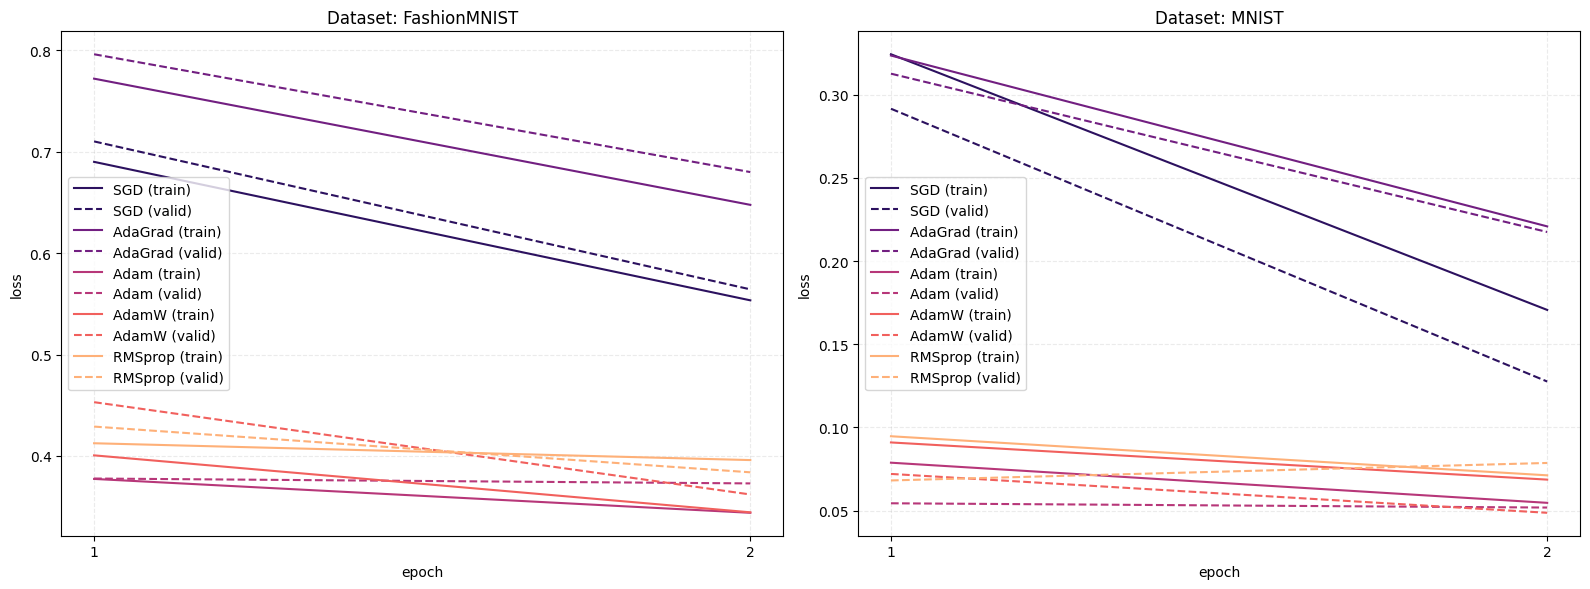

In [11]:
cols = len(datasets)
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(8 * cols, 6), tight_layout=True)
colors = sns.color_palette("magma", len(optimizers))

for dataset_idx, (dataset_name, dataset) in enumerate(datasets.items()):
    for optimizer_idx, (optimizer_name, optimizer) in enumerate(optimizers.items()):
        results_df = pd.read_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv")
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["train_loss"],
            label=f"{optimizer_name} (train)",
            color=colors[optimizer_idx],
        )
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["valid_loss"],
            label=f"{optimizer_name} (valid)",
            color=colors[optimizer_idx],
            linestyle="--",
        )

    ax[dataset_idx].set_title(f"Dataset: {dataset_name}")
    ax[dataset_idx].set_xticks(np.arange(1, NUMBER_OF_EPOCHS + 1, step=1))
    ax[dataset_idx].set_xlabel("epoch")
    ax[dataset_idx].set_ylabel("loss")
    ax[dataset_idx].grid(linestyle="--", alpha=0.25)
    ax[dataset_idx].legend()

fig.savefig(f"{RESULT_PATH}/plot_loss.png")